In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier

In [3]:
train_data = pd.read_csv('train_data.csv')
train_data_copy = train_data.copy(deep=True)
# Make a deep copy, leave orginal dataset intact.

train_data_copy.info()
# Load train data and have a first look

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134420 entries, 0 to 134419
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   UserID                  134420 non-null  object 
 1   QuestionTiming          134420 non-null  object 
 2   TimeUtc                 134420 non-null  object 
 3   CurrentGameMode         117407 non-null  object 
 4   CurrentTask             117407 non-null  object 
 5   CurrentSessionLength    134420 non-null  int64  
 6   LastTaskCompleted       71815 non-null   object 
 7   LevelProgressionAmount  117402 non-null  float64
 8   QuestionType            134420 non-null  object 
 9   ResponseValue           134420 non-null  float64
dtypes: float64(2), int64(1), object(7)
memory usage: 10.3+ MB


In [4]:
na_counts = train_data_copy.isnull().sum()
print(f'Miss value in each colums: \n{na_counts}')
print()
na_rate = na_counts / len(train_data_copy) * 100
print(f'missing value rate: \n{round(na_rate, 2)}')
# Figure out how many NA values within each column of train dataset.
# To decide whether to delete missing value or imputation, we need check na rate. 
# As we can see below, non of them above 50%, so we have to imputate them properly.

Miss value in each colums: 
UserID                        0
QuestionTiming                0
TimeUtc                       0
CurrentGameMode           17013
CurrentTask               17013
CurrentSessionLength          0
LastTaskCompleted         62605
LevelProgressionAmount    17018
QuestionType                  0
ResponseValue                 0
dtype: int64

missing value rate: 
UserID                     0.00
QuestionTiming             0.00
TimeUtc                    0.00
CurrentGameMode           12.66
CurrentTask               12.66
CurrentSessionLength       0.00
LastTaskCompleted         46.57
LevelProgressionAmount    12.66
QuestionType               0.00
ResponseValue              0.00
dtype: float64


In [5]:
for column in train_data_copy:
    if train_data_copy[column].isnull().any():
        column_type = train_data_copy[column].dtypes
        print(column, column_type)

# Check data types of each column containing missing values.
# Because first three columns are all categorical type, we could imputate missing values with mode or assign them to a new type, Unkown or not specified. 

CurrentGameMode object
CurrentTask object
LastTaskCompleted object
LevelProgressionAmount float64


"\nSince 'LevelProgressionAmount' is a numeric column, we have to check its distribution to decide using which data to imputate. \nAnd result indicated that it is a skewed data with high frequency at the end of the range. Thus, using median is more proper than mean.\n"

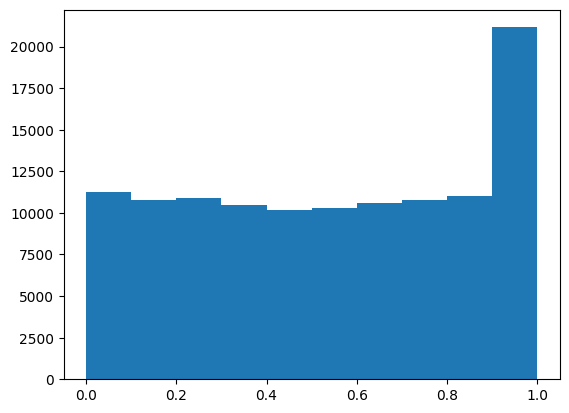

In [6]:
plt.hist(train_data_copy['LevelProgressionAmount'])

"""
Since 'LevelProgressionAmount' is a numeric column, we have to check its distribution to decide using which data to imputate. 
And result indicated that it is a skewed data with high frequency at the end of the range. Thus, using median is more proper than mean.
"""

In [7]:
for column in train_data_copy:
    if train_data_copy[column].isnull().any() and train_data_copy[column].dtype == 'object':
        mode = train_data_copy[column].mode()[0]
        train_data_copy[column] = train_data_copy[column].fillna(mode)

# Substituting missing values with mode for categorical columns.

In [39]:
# Substituting missing values with median and reassigning the column
median = train_data_copy['LevelProgressionAmount'].median()
train_data_copy['LevelProgressionAmount'] = train_data_copy['LevelProgressionAmount'].fillna(median)

In [40]:
train_data_copy.info()

# Re-check train_data, now all missing values have been filled.

<class 'pandas.core.frame.DataFrame'>
Index: 122629 entries, 0 to 134419
Data columns (total 27 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   CurrentSessionLength       122629 non-null  int64  
 1   LevelProgressionAmount     122629 non-null  float64
 2   ResponseValue              122629 non-null  float64
 3   QT_User Initiated          122629 non-null  bool   
 4   CGM_Challenge              122629 non-null  bool   
 5   CGM_FreePlay               122629 non-null  bool   
 6   CGM_Special                122629 non-null  bool   
 7   CurrentTask_encoded        122629 non-null  float64
 8   LastTaskCompleted_encoded  122629 non-null  float64
 9   Year                       122629 non-null  int32  
 10  Month                      122629 non-null  int32  
 11  Day                        122629 non-null  int32  
 12  Hour                       122629 non-null  int32  
 13  Minute                     122629 

Above are missing values imputation, following will check outliers for numeric columns

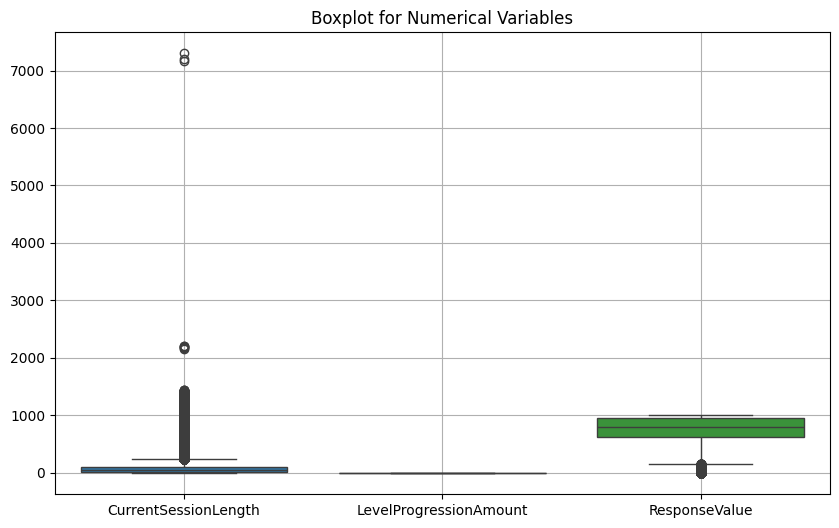

In [10]:
numeric_columns = train_data_copy[['CurrentSessionLength', 
                                   'LevelProgressionAmount', 
                                   'ResponseValue']]
plt.figure(figsize=(10, 6))
sns.boxplot(data=numeric_columns)
plt.title('Boxplot for Numerical Variables')
plt.grid(True)
plt.show()

# There are three numeric columns, check their outliers repectively.

In [11]:
numeric_columns_with_outliers = ['CurrentSessionLength', 'ResponseValue']

Q1 = train_data_copy[numeric_columns_with_outliers].quantile(0.25)
Q3 = train_data_copy[numeric_columns_with_outliers].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

mask = pd.Series(True, index=train_data_copy.index)

for col in numeric_columns_with_outliers:
    col_mask = (train_data_copy[col] >= lower_bound[col]) & (train_data_copy[col] <= upper_bound[col])
    mask &= col_mask

train_data_copy = train_data_copy[mask]

# Trim outliers for 'CurrentSessionLength' and 'ResponseValue'.

We are done with numeric columns, following parts are detecting anomalies for categorical columns!

In [12]:
for column in train_data_copy:
    if train_data_copy[column].dtype == 'object':
        print(f'{column}: {train_data_copy[column].nunique()}')

# Check how many unique values within each categorical column to find out what kind of encoding method could apply.

# 'QuestionType' only contains 1 result, it is useless for building model, thus, we could drop it.

UserID: 8145
QuestionTiming: 2
TimeUtc: 120501
CurrentGameMode: 4
CurrentTask: 47
LastTaskCompleted: 51
QuestionType: 1


In [13]:
categorical_columns = ['CurrentTask', 'LastTaskCompleted']
for col in categorical_columns:
    value_counts = train_data_copy[col].value_counts()
    print(f"\nValue counts for {col}:\n{value_counts[value_counts < 5]}")

# Check rare categories in columns with large amount of unique values.
# although, there are some categories are rare(occurred less than 5 times), 
# I perfer to keep them for accuracy, if it effect efficiency of model, then we may find a way to handle them.


Value counts for CurrentTask:
CurrentTask
TIME_HOME_DIRTBIKE                2
TIME_HOME_MOTORBIKESIDECAR        1
WATER_HOME_GOLFCART               1
TIME_RESIDENTIALSMALL_BACKYARD    1
Name: count, dtype: int64

Value counts for LastTaskCompleted:
Series([], Name: count, dtype: int64)


Now, we will encode categorical columns! (Before that, we first drop useless column)

In [14]:
# Since QuestionType only contains one category(helpless for learning), we drop this column.
train_data_copy.drop('QuestionType', axis=1, inplace=True)
# I run more than once of above code, the QuestionType already been deleted, so I make it as a comment, otherwise it wll pop error.

In [15]:
print(train_data_copy.columns)

# Check columns after drop useless column.

Index(['UserID', 'QuestionTiming', 'TimeUtc', 'CurrentGameMode', 'CurrentTask',
       'CurrentSessionLength', 'LastTaskCompleted', 'LevelProgressionAmount',
       'ResponseValue'],
      dtype='object')


Let's encode QuestionTiming and CurrentGameMode first, because they have few categories, we use one-hot encoding.

In [16]:
train_data_copy = pd.get_dummies(train_data_copy, columns=['QuestionTiming', 'CurrentGameMode'], 
                                 prefix=['QT', 'CGM'],
                                 drop_first=True)

# QT for QuestionTiming, CGM for CurrentGameMode.


In [17]:
train_data_copy.head()

,UserID,TimeUtc,CurrentTask,CurrentSessionLength,LastTaskCompleted,LevelProgressionAmount,ResponseValue,QT_User Initiated,CGM_Challenge,CGM_FreePlay,CGM_Special
0,p1,2022-08-18 22:55:27,RECREATIONGROUND_PLAYGROUND,2,WASH_PWVan,NaN,509.0,True,False,False,False
1,p1,2022-08-18 23:38:31,RECREATIONGROUND_PLAYGROUND,0,WASH_PWVan,NaN,653.0,False,False,False,False
2,p1,2022-08-18 23:39:24,HOME_VAN,1,WASH_PWVan,1.000000,705.0,True,False,False,False
3,p1,2022-08-18 23:45:01,RESIDENTIALSMALL_BACKYARD,6,WASH_PWVan,0.168267,817.0,False,False,False,False
4,p1,2022-08-18 23:51:22,RESIDENTIALSMALL_BACKYARD,13,WASH_PWVan,0.429364,810.0,False,False,False,False


Now, Let's handle CurrentTask and LastTaskCompleted, they have large amount of unique values.

In [18]:
encoder = TargetEncoder()
train_data_copy['CurrentTask_encoded'] = encoder.fit_transform(train_data_copy['CurrentTask'], 
                                                               train_data_copy['ResponseValue'])

train_data_copy['LastTaskCompleted_encoded'] = encoder.fit_transform(train_data_copy['LastTaskCompleted'], 
                                                                     train_data_copy['ResponseValue'])

train_data_copy.drop(['CurrentTask', 'LastTaskCompleted'], axis=1, inplace=True)

# encoding and drop original columns.

In [19]:
print(train_data_copy[['CurrentTask_encoded', 'LastTaskCompleted_encoded']].head())
# Check result.

   CurrentTask_encoded  LastTaskCompleted_encoded
0           734.003456                 754.212355
1           734.003456                 754.212355
2           750.944210                 754.212355
3           770.176924                 754.212355
4           770.176924                 754.212355


OK, now we have TimeUtc left, this column is tricky!

In [20]:
# Ensure TimeUtc is a datetime type
train_data_copy['TimeUtc'] = pd.to_datetime(train_data_copy['TimeUtc'])

# Extract components
train_data_copy['Year'] = train_data_copy['TimeUtc'].dt.year
train_data_copy['Month'] = train_data_copy['TimeUtc'].dt.month
train_data_copy['Day'] = train_data_copy['TimeUtc'].dt.day
train_data_copy['Hour'] = train_data_copy['TimeUtc'].dt.hour
train_data_copy['Minute'] = train_data_copy['TimeUtc'].dt.minute
train_data_copy['Second'] = train_data_copy['TimeUtc'].dt.second




In [21]:
# Separate week and weekend
train_data_copy['DayOfWeek'] = train_data_copy['TimeUtc'].dt.dayofweek
train_data_copy['IsWeekend'] = (train_data_copy['TimeUtc'].dt.weekday >= 5).astype(int)

# Assign different period of time to different categories. 
bins = [0, 6, 12, 18, 24]  # Define bins as 0-6, 6-12, 12-18, 18-24
labels = ['Night', 'Morning', 'Afternoon', 'Evening']
train_data_copy['TimeOfDay'] = pd.cut(train_data_copy['TimeUtc'].dt.hour, bins=bins, labels=labels, right=False)

# Drop original column to reduce redundancy
train_data_copy.drop('TimeUtc', axis=1, inplace=True)

In [22]:
# Check dataset.
train_data_copy.head()

,UserID,CurrentSessionLength,LevelProgressionAmount,ResponseValue,QT_User Initiated,CGM_Challenge,CGM_FreePlay,CGM_Special,CurrentTask_encoded,LastTaskCompleted_encoded,Year,Month,Day,Hour,Minute,Second,DayOfWeek,IsWeekend,TimeOfDay
0,p1,2,NaN,509.0,True,False,False,False,734.003456,754.212355,2022,8,18,22,55,27,3,0,Evening
1,p1,0,NaN,653.0,False,False,False,False,734.003456,754.212355,2022,8,18,23,38,31,3,0,Evening
2,p1,1,1.000000,705.0,True,False,False,False,750.944210,754.212355,2022,8,18,23,39,24,3,0,Evening
3,p1,6,0.168267,817.0,False,False,False,False,770.176924,754.212355,2022,8,18,23,45,1,3,0,Evening
4,p1,13,0.429364,810.0,False,False,False,False,770.176924,754.212355,2022,8,18,23,51,22,3,0,Evening


In [23]:
# Check data type again.
for column in train_data_copy:
    print(f'{column}: {train_data_copy[column].dtype}')

UserID: object
CurrentSessionLength: int64
LevelProgressionAmount: float64
ResponseValue: float64
QT_User Initiated: bool
CGM_Challenge: bool
CGM_FreePlay: bool
CGM_Special: bool
CurrentTask_encoded: float64
LastTaskCompleted_encoded: float64
Year: int32
Month: int32
Day: int32
Hour: int32
Minute: int32
Second: int32
DayOfWeek: int32
IsWeekend: int32
TimeOfDay: category


Define a cyclical encoding function to encode time related features. 

In [27]:
def cyclical_encode(data, max_val):
    data_rad = (2 * np.pi * data) / max_val
    return np.sin(data_rad), np.cos(data_rad)


In [28]:
# Encoding year, month, day.
train_data_copy['month_sin'], train_data_copy['month_cos'] = cyclical_encode(train_data_copy['Month'], 12)
train_data_copy['day_sin'], train_data_copy['day_cos'] = cyclical_encode(train_data_copy['Day'], 31)
train_data_copy['year_sin'], train_data_copy['year_cos'] = cyclical_encode(train_data_copy['Year'], train_data_copy['Year'].max())

In [32]:
# finally, we need one last encoding for TimeOfDay.
train_data_copy = pd.get_dummies(train_data_copy, columns=['TimeOfDay'], prefix='ToD', drop_first=False)


I have no idea about how to process UserID, for now, I simply delete it.

In [33]:
# Drop UserID.
train_data_copy.drop('UserID', axis=1, inplace=True)


In [34]:
train_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 122629 entries, 0 to 134419
Data columns (total 27 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   CurrentSessionLength       122629 non-null  int64  
 1   LevelProgressionAmount     106068 non-null  float64
 2   ResponseValue              122629 non-null  float64
 3   QT_User Initiated          122629 non-null  bool   
 4   CGM_Challenge              122629 non-null  bool   
 5   CGM_FreePlay               122629 non-null  bool   
 6   CGM_Special                122629 non-null  bool   
 7   CurrentTask_encoded        122629 non-null  float64
 8   LastTaskCompleted_encoded  122629 non-null  float64
 9   Year                       122629 non-null  int32  
 10  Month                      122629 non-null  int32  
 11  Day                        122629 non-null  int32  
 12  Hour                       122629 non-null  int32  
 13  Minute                     122629 

Then I will scaling numerical features and use random forest to do feature selection.

In [45]:
# Separate features and target
X = train_data_copy.drop(['ResponseValue'], axis=1)  # Dropping the target from the feature set
y = train_data_copy['ResponseValue']  # This is your target variable

# Define numeric features
numeric_features = ['CurrentSessionLength', 'LevelProgressionAmount', 'CurrentTask_encoded', 'LastTaskCompleted_encoded']
cyclical_features = ['month_sin', 'month_cos', 'day_sin', 'day_cos', 'year_sin', 'year_cos']

# Pipeline for numeric transformations
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Preprocessor to apply transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features + cyclical_features)
    ],
    remainder='passthrough')  # Keeps boolean and already encoded categorical features as is

# Complete pipeline with classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(f_classif, k=10)), 
    ('classifier', RandomForestClassifier())
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
pipeline.fit(X_train, y_train)

# Evaluate the model
print("Model accuracy on test set: ", pipeline.score(X_test, y_test))




Model accuracy on test set:  0.059406344287694694
